# 深度学习100例 | 第24天-卷积神经网络（Xception）：动物识别

## 1. 前期准备

### 1.1 导入数据

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

import pathlib

《深度学习100例》第24天的数据链接如下：

https://pan.baidu.com/s/1eiJgSOG4KAxlqwtU9kFvIA（提取码：1dfi）

In [2]:
data_dir = "F:\DeepLearning\day-24\data"

data_dir = pathlib.Path(data_dir)

### 1.2 查看数据

In [3]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 4000


## 2.数据预处理

### 2.1 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [4]:
batch_size = 2
img_height = 299
img_width  = 299

TensorFlow版本是2.2.0的同学可能会遇到`module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'`的报错，升级一下TensorFlow就OK了。

In [5]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.


In [6]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 800 files for validation.


我们可以通过class\_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [7]:
class_names = train_ds.class_names
print(class_names)

['cat', 'chook', 'dog', 'horse']


### 2.2 再次检查数据

- `Image_batch`是形状的张量（2, 299, 299, 3\)。这是一批形状240x240x3的8张图片（最后一维指的是彩色通道RGB）。
- `Label_batch`是形状（8，）的张量，这些标签对应8张图片

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(2, 299, 299, 3)
(2,)


### 2.3 配置数据集

 -    **shuffle\(\)** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
 -    **prefetch\(\)** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
 -    **cache\(\)** ：将数据集缓存到内存当中，加速运行

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds.cache()
    .shuffle(1000)
#     .map(train_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)           # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
#     .map(val_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)         # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

## 3.构建模型

`Xception`是谷歌公司继`Inception`后，提出的`InceptionV3`的一种改进模型，其中`Inception`模块已被深度可分离卷积（depthwise separable convolution）替换。它与`Inception-v1`（23M）的参数数量大致相同。

![](https://img-blog.csdnimg.cn/67be720d7ce94b5d85556d44b331f3ed.png)

### 3.1 深度可分离卷积

**深度可分离卷积其实是一种可分解卷积操作（factorized convolutions）。其可以分解为两个更小的操作：depthwise convolution 和 pointwise convolution。**

![](https://img-blog.csdnimg.cn/d125e0a248374772915efca8cecb4617.png?x-oss-process=image/watermark,type_ZHJvaWRzYW5zZmFsbGJhY2s,shadow_50,text_Q1NETiBAS-WQjOWtpuWVig==,size_20,color_FFFFFF,t_70,g_se,x_16)  
**（1）标准卷积**

下面先学习标准的卷积操作：

![](https://img-blog.csdnimg.cn/80775433fe884fc7adae1f8d90ea9dcd.png?x-oss-process=image/watermark,type_ZHJvaWRzYW5zZmFsbGJhY2s,shadow_50,text_Q1NETiBAS-WQjOWtpuWVig==,size_20,color_FFFFFF,t_70,g_se,x_16)

输入一个12_12_3的一个输入特征图，经过 5_5_3的卷积核得到一个8_8_1的输出特征图。如果我们此时有256个卷积核，我们将会得到一个8_8_256的输出特征图。

以上就是标准卷积做的活，那么深度卷积和逐点卷积呢？

**（2）深度卷积**

![](https://img-blog.csdnimg.cn/37450da146b24d4690974794e835e074.png?x-oss-process=image/watermark,type_ZHJvaWRzYW5zZmFsbGJhY2s,shadow_50,text_Q1NETiBAS-WQjOWtpuWVig==,size_20,color_FFFFFF,t_70,g_se,x_16)

与标准卷积网络不一样的是，这里会将卷积核拆分成单通道形式，在不改变输入特征图像的深度的情况下，对每一通道进行卷积操作，这样就得到了和输入特征图通道数一致的输出特征图。如上图，输入12x12x3 的特征图，经过5x5x1x3的深度卷积之后，得到了8x8x3的输出特征图。输入和输出的维度是不变的3，这样就会有一个问题，通道数太少，特征图的维度太少，能获得足够的有效信息吗\?

**\(3\)逐点卷积**

逐点卷积就是1\*1卷积，主要作用就是对特征图进行升维和降维，如下图：

![](https://img-blog.csdnimg.cn/414e3d108e5949deb8d985d8867632ee.png?x-oss-process=image/watermark,type_ZHJvaWRzYW5zZmFsbGJhY2s,shadow_50,text_Q1NETiBAS-WQjOWtpuWVig==,size_20,color_FFFFFF,t_70,g_se,x_16)

在深度卷积的过程中，我们得到了8x8x3的输出特征图，我们用256个1x1x3的卷积核对输入特征图进行卷积操作，输出的特征图和标准的卷积操作一样都是8x8x256了。

标准卷积与深度可分离卷积的过程对比如下：

![](https://img-blog.csdnimg.cn/71906c42dd71476e86289de856011f21.png?x-oss-process=image/watermark,type_ZHJvaWRzYW5zZmFsbGJhY2s,shadow_50,text_Q1NETiBAS-WQjOWtpuWVig==,size_20,color_FFFFFF,t_70,g_se,x_16)

**\(4\)为什么要用深度可分离卷积？**

深度可分离卷积可以实现更少的参数，更少的运算量。

### 3.2 构建Xception模型

In [10]:
#====================================#
#     Xception的网络部分
#====================================#
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Activation,Conv2D,SeparableConv2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions


def Xception(input_shape = [299,299,3],classes=1000):

    img_input = Input(shape=input_shape)
    
    #=================#
    #   Entry flow
    #=================#
    #  block1
    # 299,299,3 -> 149,149,64
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)


    # block2
    # 149,149,64 -> 75,75,128
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    # block3
    # 75,75,128 -> 38,38,256
    residual = Conv2D(256, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    # block4
    # 38,38,256 -> 19,19,728
    residual = Conv2D(728, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    #=================#
    # Middle flow
    #=================#
    # block5--block12
    # 19,19,728 -> 19,19,728
    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    #=================#
    #    Exit flow
    #=================#
    # block13
    # 19,19,728 -> 10,10,1024
    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    # block14
    # 10,10,1024 -> 10,10,2048
    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input

    model = Model(inputs, x, name='xception')

    return model

In [11]:
model = Xception()
# 打印模型信息
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

## 4.设置动态学习率

这里先罗列一下学习率大与学习率小的优缺点。

- 学习率大

  - 优点：  
    1、加快学习速率。  
    2、有助于跳出局部最优值。
  - 缺点：  
    1、导致模型训练不收敛。  
    2、单单使用大学习率容易导致模型不精确。

- 学习率小

  - 优点：  
    1、有助于模型收敛、模型细化。  
    2、提高模型精度。
  - 缺点：  
    1、很难跳出局部最优值。  
    2、收敛缓慢。

注意：这里设置的动态学习率为：指数衰减型（ExponentialDecay）。在每一个epoch开始前，学习率（learning\_rate）都将会重置为初始学习率（initial\_learning\_rate），然后再重新开始衰减。计算公式如下：

> learning\_rate = initial\_learning\_rate \* decay\_rate \^ \(step / decay\_steps\)

In [12]:
# 设置初始学习率
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=300,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,     # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

## 5.编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

 -    优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
 -    损失函数（loss）：用于估量预测值与真实值的不一致程度。
 -    评价函数（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [13]:
model.compile(optimizer=optimizer,
              loss     ='sparse_categorical_crossentropy',
              metrics  =['accuracy'])

## 6.训练模型

In [14]:
epochs = 1

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

1600/1600 [==============================] - 2487s 2s/step - loss: 1.4117 - accuracy: 0.4072 - val_loss: 1.5335 - val_accuracy: 0.4462


## 7.模型评估

### 7.1 Accuracy与Loss图

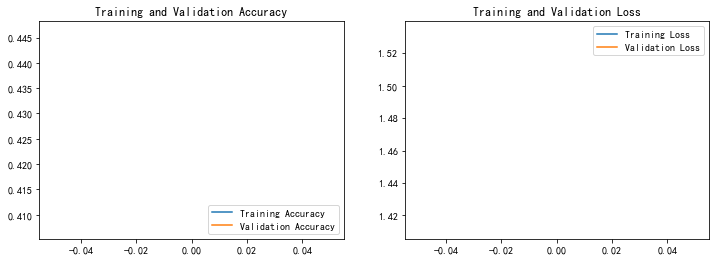

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 7.2 混淆矩阵

Seaborn 是一个画图库，它基于 Matplotlib 核心库进行了更高阶的 API 封装，可以让你轻松地画出更漂亮的图形。Seaborn 的漂亮主要体现在配色更加舒服、以及图形元素的样式更加细腻。

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('混淆矩阵',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

In [17]:
val_pre   = []
val_label = []

for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 184ms/step


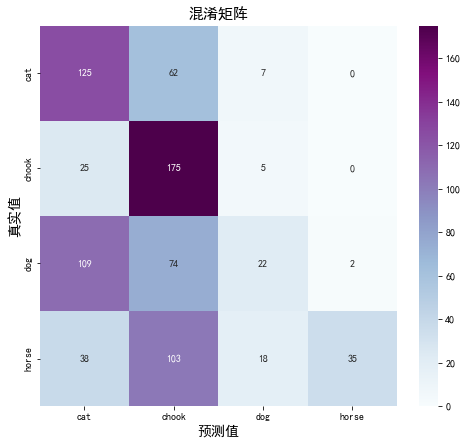

In [18]:
plot_cm(val_label, val_pre)

## 8.保存和加载模型

In [19]:
# 保存模型
model.save('model/24_model.h5')

In [20]:
# 加载模型
new_model = tf.keras.models.load_model('model/24_model.h5')